In [1]:
#import all library required
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

#style your matplotlib
mpl.style.use("seaborn-v0_8-whitegrid")
#run this block

In [2]:
from tqdm import tqdm #show progress bar of got loop

Display files in 'train' folder

In [3]:
files=os.listdir("train")
files

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Creating image and label array

In [4]:
image_array=[] #it's a list later i will convert it to array
label_array=[]
path="train/"
#loop through each sub-folder in train
for i in range(len(files)):
    #files in sub-folder
    file_sub=os.listdir(path+files[i])
    
    # print(len(file_sub))
    #loop through each files
    #for neutral and happy dataset i will reduce from 20+k to 1900 due to low ram memory
    if(files[i]=="neutral" or files[i]=="happy"):
        for k in tqdm(range(19000)):
            #read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            #convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            #append image_array with img
            image_array.append(img)
            label_array.append(i)
            #i is integer from 0-6
            #run this block
    else:
        #for other dataset
        for k in tqdm(range(len(file_sub))):
            #read imahe
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            #convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            #append image_array with img
            image_array.append(img)
            label_array.append(i)
            #i is integer from 0-6

100%|██████████| 8113/8113 [00:05<00:00, 1612.00it/s]


In [5]:
a,b=np.unique(label_array,return_counts="True")
a

array([0, 1, 2, 3, 4, 5, 6])

In [6]:
b

array([ 6566,  3231,  4859, 19000, 19000, 12223,  8113], dtype=int64)

In [7]:
import gc
gc.collect()

9

In [8]:
#now divide image_array by 255.0
#this will scale image pixel from 0-255 to0-1
image_array=np.array(image_array)/255.0
#convert label list to array
label_array=np.array(label_array)

shuffle and split image and labels into train and test

In [9]:
from sklearn.model_selection import train_test_split
image_array,X_test,Y_train,Y_test=train_test_split(image_array,label_array,test_size=0.1)
#using 10% for validation

#now before running this block change X_train to image_array to save ram memory
gc.collect()

0

In [10]:
#to see image and label
#define dic for converting label to test_label
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

In [11]:
label_to_text[1]

'fear'

define a function, show examples

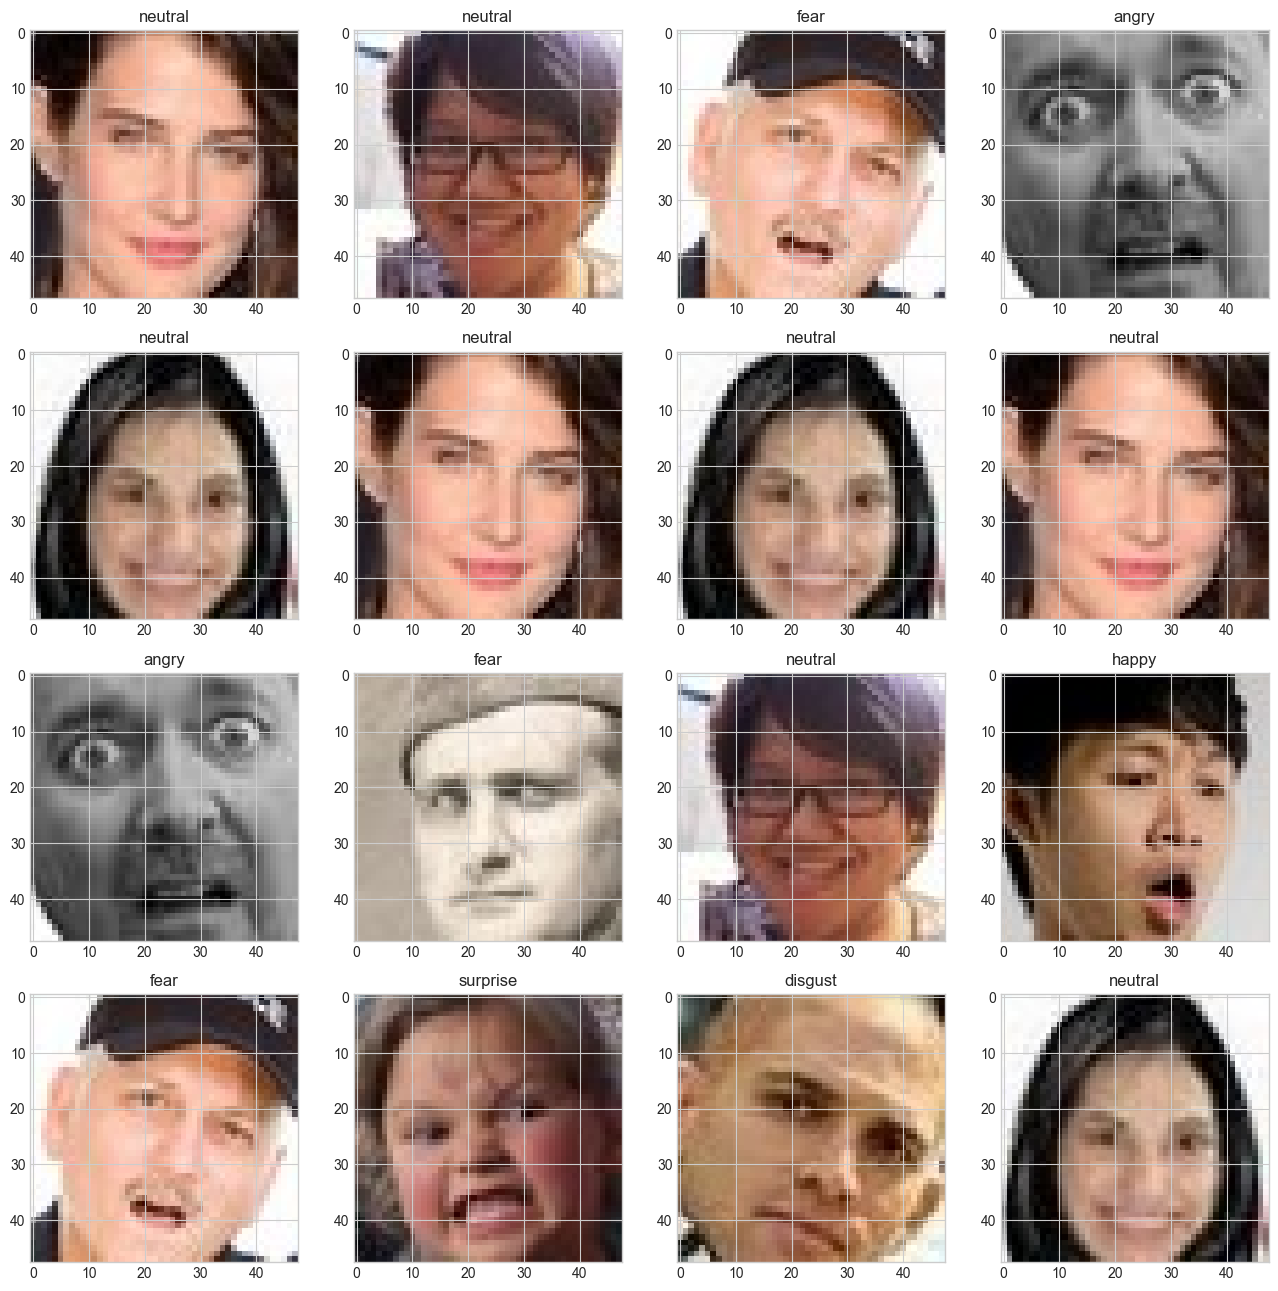

In [12]:
def show_examples(image,label,idx):
    #create 4x4 figure
    fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(16,16))
    #loop through each figure
    for idx_f,ax in zip(idx,axes.ravel()):
        #add image to figure
        ax.imshow(image[idx_f].squeeze(),cmap="gray")
        #add title to each figure
        ax.set_title(label_to_text[label[idx_f]])
    plt.show()
idx=np.random.choice(16,16)
show_examples(image_array,Y_train,idx)

start training model by import all library required

In [13]:
from keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential,Model

In [14]:
model=Sequential()
#i will use MobileNetV2 as a pretrained model
pretrained_model=applications.MobileNetV2(input_shape=(48,48,3),include_top=False, weights="imagenet")

#change all non-trainable layer to trainable
pretrained_model.trainable=True
#add pretrained_model to model
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
#add dropout to increase accuracy by not overfitting
model.add(layers.Dropout(0.3))
#add dense layer as final output
model.add(layers.Dense(1))
model.summary()

C:\Users\user\AppData\Local\Temp\ipykernel_13828\1376648239.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model=applications.MobileNetV2(input_shape=(48,48,3),include_top=False, weights="imagenet")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [15]:
from tensorflow.keras.optimizers import Adam

compile model

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

In [17]:
#create model checkpoint
ckp_path="trained_model.weights.h5"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                   monitor="val_mae",
                                                   mode="auto",
                                                   save_best_only=True,
                                                   save_weights_only=True)
#this checkpoint save model when val_mae is lower then best val_mae

In [18]:
#define learning rate reducer
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(factor=0.9,
                                              monitor="val_mae",
                                              mode="auto",
                                              cooldown=0,
                                              patience=3,
                                              verbose=1,
                                              min_lr=1e-6)
#this will decrease learning rate when val_mae doesnt decrease during last 5 epoch
#verbose is use to show val_mae every epoch

In [19]:
EPOCHS=2
BATCH_SIZE=128
#start training
history=model.fit(image_array,Y_train,
                 validation_data=(X_test,Y_test),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[model_checkpoint,reduce_lr])

Epoch 1/2
514/514 ━━━━━━━━━━━━━━━━━━━━ 497s 899ms/step - loss: 3.7407 - mae: 1.5016 - val_loss: 14.9144 - val_mae: 3.2808 - learning_rate: 0.0010
Epoch 2/2
514/514 ━━━━━━━━━━━━━━━━━━━━ 454s 883ms/step - loss: 2.3320 - mae: 1.1493 - val_loss: 12.7222 - val_mae: 3.1911 - learning_rate: 0.0010


In [20]:
# Evaluate the model using accuracy
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 12.4925 - mae: 3.1634
Test Loss: 12.731842041015625, Test Accuracy: 3.191054344177246


In [21]:
#after training is finished
#load model
model.load_weights(ckp_path)

In [23]:
#if want to see result
prediction_val=model.predict(X_test,batch_size=BATCH_SIZE)

58/58 [==============================] - 2s 13ms/step


In [24]:
#prediction value
prediction_val[:10]

array([[2.987919 ],
       [1.9350147],
       [3.7767322],
       [5.9901104],
       [3.990464 ],
       [2.991939 ],
       [4.898561 ],
       [2.9986117],
       [2.9915955],
       [2.1928573]], dtype=float32)

In [25]:
#original value
Y_test[:10]

array([1, 4, 5, 6, 3, 3, 6, 3, 0, 4])

In [25]:
# Save the model
model.save("emotion_detection_model.h5")

# Optionally, you can also save the model's weights only
#model.save_weights("emotion_detection_model_weights.h5")


ValueError: Unable to synchronously create dataset (name already exists)